Generated: 1000 simulations
Simulation runtime (sec): 2.39
Saved: sir_simulation_dataset_1000.csv
               Model        R2       MAE      RMSE  TrainTimeSec
0         ExtraTrees  0.999656  0.002439  0.003871      0.410695
1   GradientBoosting  0.999424  0.003307  0.005013      0.164376
2       RandomForest  0.999178  0.003722  0.005989      0.612510
3       DecisionTree  0.998558  0.004782  0.007930      0.004736
4                KNN  0.981777  0.018468  0.028192      0.006096
5                MLP  0.967690  0.028948  0.037538      0.096377
6                SVR  0.875321  0.062988  0.073740      0.004297
7              Lasso  0.844114  0.055003  0.082454      0.003898
8         ElasticNet  0.843705  0.055078  0.082562      0.001610
9              Ridge  0.843339  0.055161  0.082658      0.006783
10  LinearRegression  0.842861  0.055154  0.082785      0.001974
Saved: model_comparison_table.csv


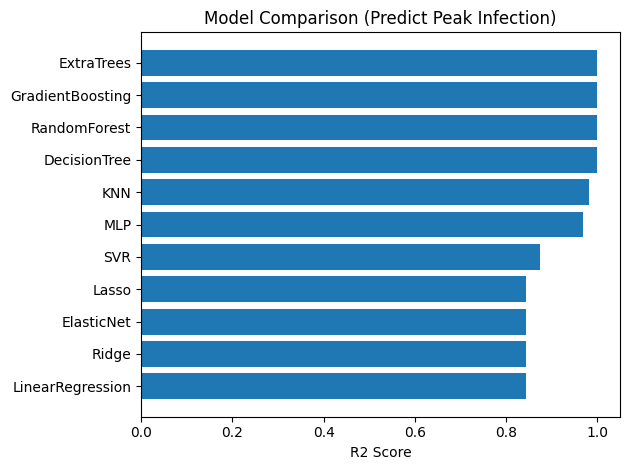

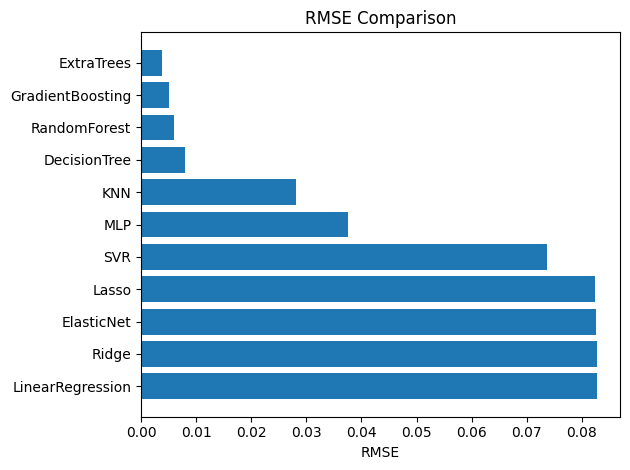


BEST MODEL: ExtraTrees
R2: 0.9996564169227315
MAE: 0.0024385022293010724
RMSE: 0.0038709983589482995


In [2]:
!pip -q install numpy pandas matplotlib scikit-learn scipy

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


def sir_ode(t, y, beta, gamma):
    S, I, R = y
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return [dS, dI, dR]


bounds = {
    "beta":  (0.05, 1.50),
    "gamma": (0.05, 1.00),
    "I0":    (0.001, 0.10),
    "days":  (60, 200)
}


def run_sim(beta, gamma, I0, days, n_points=200):
    S0 = 1.0 - I0
    R0 = 0.0
    t_eval = np.linspace(0, days, n_points)

    sol = solve_ivp(
        fun=lambda t, y: sir_ode(t, y, beta, gamma),
        t_span=(0, days),
        y0=[S0, I0, R0],
        t_eval=t_eval,
        method="RK45"
    )

    S, I, R = sol.y

    peak_I = float(I.max())
    t_peak = float(t_eval[int(I.argmax())])
    final_R = float(R[-1])

    return peak_I, t_peak, final_R


rng = np.random.default_rng(42)
N = 1000

rows = []

start_sim = time.perf_counter()

for _ in range(N):

    beta  = float(rng.uniform(*bounds["beta"]))
    gamma = float(rng.uniform(*bounds["gamma"]))
    I0    = float(rng.uniform(*bounds["I0"]))
    days  = int(rng.integers(bounds["days"][0], bounds["days"][1] + 1))

    peak_I, t_peak, final_R = run_sim(beta, gamma, I0, days)

    rows.append({
        "beta": beta,
        "gamma": gamma,
        "I0": I0,
        "days": days,
        "R0_basic": beta / gamma,
        "peak_I": peak_I,
        "t_peak": t_peak,
        "final_R": final_R
    })


end_sim = time.perf_counter()

df = pd.DataFrame(rows)

print("Generated:", len(df), "simulations")
print("Simulation runtime (sec):", round(end_sim - start_sim, 2))

df.to_csv("sir_simulation_dataset_1000.csv", index=False)
print("Saved: sir_simulation_dataset_1000.csv")


features = ["beta", "gamma", "I0", "days", "R0_basic"]
target = "peak_I"

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "KNN": KNeighborsRegressor(n_neighbors=10),
    "SVR": SVR(C=10),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=250, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(64,64), max_iter=600, random_state=42)
}


need_scaling = {"LinearRegression","Ridge","Lasso","ElasticNet","KNN","SVR","MLP"}

results = []

for name, model in models.items():

    if name in need_scaling:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    else:
        pipe = Pipeline([("model", model)])

    start_train = time.perf_counter()
    pipe.fit(X_train, y_train)
    end_train = time.perf_counter()

    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "TrainTimeSec": (end_train - start_train)
    })


res_df = pd.DataFrame(results).sort_values(
    ["R2","RMSE"], ascending=[False, True]
).reset_index(drop=True)

print(res_df)

res_df.to_csv("model_comparison_table.csv", index=False)
print("Saved: model_comparison_table.csv")


plt.figure()
plt.barh(res_df["Model"], res_df["R2"])
plt.xlabel("R2 Score")
plt.title("Model Comparison (Predict Peak Infection)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


plt.figure()
plt.barh(res_df["Model"], res_df["RMSE"])
plt.xlabel("RMSE")
plt.title("RMSE Comparison")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


best = res_df.iloc[0]

print("\nBEST MODEL:", best["Model"])
print("R2:", best["R2"])
print("MAE:", best["MAE"])
print("RMSE:", best["RMSE"])